### Assignment 1 for Clustering:
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is 2 weeks from today: February 28, 2025 at 11:59 pm.

HINT: For those who dont have a thesis topic yet, you can actually develop a thesis topic out of this assignment.

Loaded Data:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2576
Date:                Fri, 21 Feb 2025   Prob (

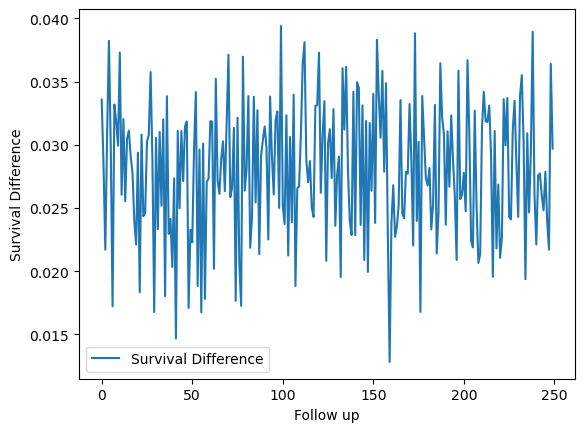

In [3]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Setup
class ITTTrial:
    def __init__(self, estimand="ITT"):
        self.estimand = estimand
        self.data = None
        self.weights = None
        self.outcome_model = None

trial_itt = ITTTrial()

# Create a directory to save files for later inspection
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

# 2. Data preparation
# Load dummy dataset
data_censored = pd.read_csv("data_censored.csv")
print("Loaded Data:")
print(data_censored.head())

# Setting the observational data for the ITT trial
trial_itt.data = data_censored

# 3. Weight models and censoring
# 3.1 Censoring due to treatment switching
def logit_model_fit(data, outcome, predictors):
    X = sm.add_constant(data[predictors])
    y = data[outcome]
    model = sm.Logit(y, X).fit(disp=False)  # Suppress console output
    return model

# Define weight models
trial_itt.switch_weight_model = logit_model_fit(
    data_censored, "treatment", ["age", "x1", "x3"]
)

trial_itt.censor_weight_model = logit_model_fit(
    data_censored, "censored", ["x2", "x1"]
)

# 4. Calculate Weights
def calculate_weights(model, data):
    predictors = model.params.index.drop("const")  # Exclude constant
    X = sm.add_constant(data[predictors])
    predictions = model.predict(X)
    return np.where(predictions > 0, 1 / predictions, 1)

trial_itt.weights = calculate_weights(trial_itt.switch_weight_model, data_censored)

# 5. Specify Outcome Model
def fit_outcome_model(data, outcome, predictors):
    X = sm.add_constant(data[predictors])
    y = data[outcome]
    model = sm.OLS(y, X).fit()
    return model

trial_itt.outcome_model = fit_outcome_model(data_censored, "outcome", ["x2"])

# 6. Expand Trials (Simulating the process)
def expand_trials(data, chunk_size=500):
    sample_size = min(len(data), chunk_size)
    return data.sample(n=sample_size, replace=(sample_size > len(data)), random_state=123)

trial_itt.expanded_data = expand_trials(data_censored)

# 7. Load or Sample from Expanded Data
np.random.seed(1234)
trial_itt.sampled_data = trial_itt.expanded_data.sample(frac=0.5, random_state=1234)

# 8. Fit Marginal Structural Model
trial_itt.sampled_data["modified_weights"] = np.minimum(
    calculate_weights(trial_itt.switch_weight_model, trial_itt.sampled_data),
    np.quantile(trial_itt.weights, 0.99)
)

trial_itt.msm_model = fit_outcome_model(trial_itt.sampled_data, "outcome", ["x2"])
print(trial_itt.msm_model.summary())

# 9. Inference
predict_times = np.arange(0, len(trial_itt.sampled_data))  # Ensure correct length
predictions = trial_itt.msm_model.predict(sm.add_constant(trial_itt.sampled_data[["x2"]]))

plt.plot(predict_times, predictions, label="Survival Difference")
plt.xlabel("Follow up")
plt.ylabel("Survival Difference")
plt.legend()
plt.show()
